In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

# returns runtime
def parse_runs(clients, norm=1):
    mean = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    maxs = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    stds = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    jobs = []
    for i in clients:
        j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*isolated*"))    
        j2 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*interfere*"))
        j3 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*isolated*"))
        j0 = [k/norm for k in j0]
        j1 = [k/norm for k in j1]
        j2 = [k/norm for k in j2]
        j3 = [k/norm for k in j3]
        mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2), np.mean(j3)]
        maxs.loc[len(maxs)] = [np.max(j0), np.max(j1), np.max(j2), np.max(j3)]
        stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2), np.std(j3)]
    return mean, stds, maxs

# Single Client Perspective
per-client throughput (when there is contention at MDS)

baseline=513.089005236


,no interference,interference
0,1.000000,1.884817
1,1.675393,2.732984
2,3.607330,5.157068
3,5.753927,7.392670
4,6.712042,8.565445


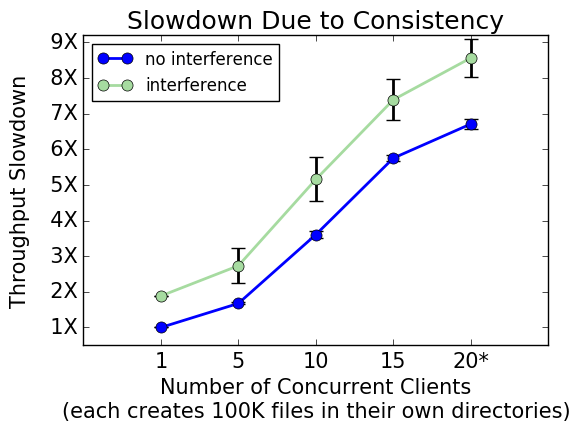

In [7]:
clients=[1, 5, 10, 15, 18]
norm = np.max(parse_mdtest(glob.glob("../results-cloudlab-clients"+str(clients[0])+"/*isolated*")))
mean, stds, maxs = parse_runs(clients, norm=norm)
m = maxs[["isolated journal", "interfere journal"]]
s = stds[["isolated journal", "interfere journal"]]
m.columns = ["no interference", "interference"]
s.columns = ["no interference", "interference"]

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
args = {'lw': 2, 'marker': 'o', 'ms': 8, 'ecolor': 'black', 'capthick': 1, 'capsize': 5}
m.plot(ax=ax, yerr=s, color=['blue', '#a6dba0'], **args)

# format!
ax.set_title("Slowdown Due to Consistency")
ax.set_xlabel("Number of Concurrent Clients\n(each creates 100K files in their own directories)")
ax.set_xlim(-1, 5)
clients[4] = "20*"
ax.set_xticklabels([""] + clients + [""], rotation=0)
ax.set_ylabel("Throughput Slowdown")
ax.set_ylim(0.5, 9.2)
ax.set_yticklabels(['{:3.0f}X'.format(x) for x in ax.get_yticks()])

# remove error bars in legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, fontsize=12, loc='upper left',numpoints=2)

# draw arrow
#arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
#args = {'horizontalalignment': 'left', 'verticalalignment': 'top', 'fontsize': 12, 'arrowprops': arrw}
#ax.annotate('baseline: ' + str(int(98000/norm)) + ' creates/sec',
#            xy=(0.1, 1), xytext=(1, 1.2), **args)

fig.savefig('../../../paper/graphs/slowdown-interfere-scale.png', bbox_inches='tight', dpi=400)
print "baseline=" + str(98000/norm)
m

# Total Job Perspective
But shows contention at MDS; throughput speeds up with more work, until it gets overloaded

baseline=513.089005236


,no interference,interference
0,1.000000,0.530556
1,3.110749,3.498168
2,3.017378,3.315972
3,2.749520,3.077336
4,2.855482,2.930946


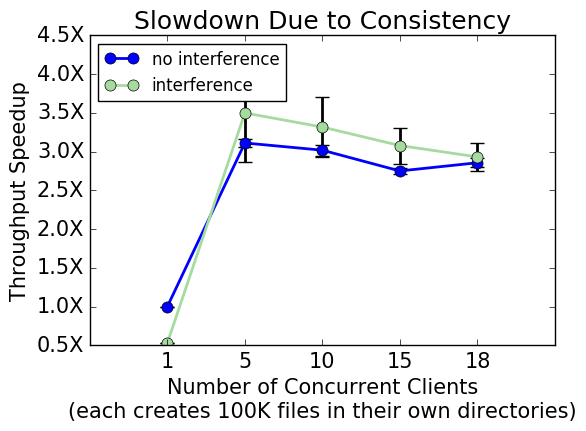

In [4]:
# returns throughput
def parse_runs_thruput(clients, norm=1):
    mean = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    maxs = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    stds = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    jobs = []
    for i in clients:
        j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*isolated*"))    
        j2 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*interfere*"))
        j3 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*isolated*"))
        j0 = [(i*98000/k)/(98000/norm) for k in j0]
        j1 = [(i*98000/k)/(98000/norm) for k in j1]
        j2 = [(i*98000/k)/(98000/norm) for k in j2]
        j3 = [(i*98000/k)/(98000/norm) for k in j3]
        mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2), np.mean(j3)]
        maxs.loc[len(maxs)] = [np.max(j0), np.max(j1), np.max(j2), np.max(j3)]
        stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2), np.std(j3)]
    return mean, stds, maxs

clients=[1, 5, 10, 15, 18]
norm = np.max(parse_mdtest(glob.glob("../results-cloudlab-clients"+str(clients[0])+"/*isolated*")))
mean, stds, maxs = parse_runs_thruput(clients, norm=norm)
m = maxs[["isolated journal", "interfere journal"]]
s = stds[["isolated journal", "interfere journal"]]
m.columns = ["no interference", "interference"]
s.columns = ["no interference", "interference"]

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
args = {'lw': 2, 'marker': 'o', 'ms': 8, 'ecolor': 'black', 'capthick': 1, 'capsize': 5}
m.plot(ax=ax, yerr=s, color=['blue', '#a6dba0'], **args)

# format!
ax.set_title("Slowdown Due to Consistency")
ax.set_xlabel("Number of Concurrent Clients\n(each creates 100K files in their own directories)")
ax.set_xlim(-1, 5)
ax.set_xticklabels([""] + clients + [""], rotation=0)
ax.set_ylabel("Throughput Speedup")
#ax.set_ylim(0.9, 9.2)
ax.set_yticklabels(['{:3.1f}X'.format(x) for x in ax.get_yticks()])

# remove error bars in legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, fontsize=12, loc='upper left',numpoints=2)

print "baseline=" + str(98000/norm)
m